# Within Blocks Analysis
By: Adam Li

Here I analyze the differences between same word pair, reversed and different word pair in the same block.

In [1]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
######## Load in EVENTS struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# print number of incorrect events and which words they belonged to
incorrectIndices = events['isCorrect'] == 0
incorrectEvents = events[incorrectIndices]
incorrectWords = []
wordList = {}
for i in range(0, len(incorrectEvents)):
    incorrectWords.append(incorrectEvents['probeWord'][i][0])

for word in np.unique(incorrectEvents['probeWord']):
    wordList[str(word)] = sum(incorrectWords == word)
    
print "There were ",len(incorrectEvents), " number of incorrect events."
print "The list of incorrect probe words: \n", wordList
# 
# get only correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "\nThis is the length of the events struct with only correct responses: ", len(events)

There were  49  number of incorrect events.
The list of incorrect probe words: 
{"[u'PANTS']": 7, "[u'JUICE']": 8, "[u'BRICK']": 12, "[u'CLOCK']": 13, "[u'GLASS']": 9}

This is the length of the events struct with only correct responses:  1431


## Looking at Each Session Within Block Analysis

1. Get data structure of same groups, reverse groups, and different groups
2. For each group plot pairwise histogram of feature distances

In [59]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1]
# freq_bands = np.arange(0,7,1)

np.random.seed(123456789)  # for reproducibility, set random seed

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0, 1]
['delta', 'theta']
The length of the feature vector for each channel will be:  10


In [60]:
### Functions to help extract features and plot histogram of distances
# loops through each wordpairing group and extract features
def extractFeatures(wordgroup, session, block, block_dir):
    PairFeatureDict = {}
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = block_dir + '/' + pairs[0]
        second_wordpair_dir = block_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels for each 
        channels = os.listdir(first_wordpair_dir)
        # loop through channels
        for jdx, chans in enumerate(channels):
            # Each wordpair's fullfile dir path
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            ## 0: load in data
            data_first = scipy.io.loadmat(first_chan_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_chan_file)
            data_second = data_second['data']

            ## 01: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 02: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]

            ## 03: Get Power Matrix
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]

            ### 1: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
                first_mean.append(np.mean(first_matrix[i,:,first_timeZero:first_vocalization[i]], axis=1))
#                     first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
                second_mean.append(np.mean(second_matrix[i,:,second_timeZero:second_vocalization[i]], axis=1))
#                     second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))

            # create feature vector for each event
            if jdx == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels
        
        # should be #events X #features (channels x freq. bands x time points)
#         if idx==0:
#             print first_pair_features.shape
#             print second_pair_features.shape
        
        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict
 
def computePairDistances(first_mat, second_mat):
    distance_list = []

    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
#     for idx in range(0, second_mat.shape[0]):
#         distance_list.append([distances(x, second_mat[idx,:]) for x in first_mat])
        
    distance_list = np.ndarray.flatten(np.array(distance_list))

    return distance_list    

Analyzing session  session_1
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
Done
Analyzing  JUICE_GLASSvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsBRICK_CLOCK
Analyzing  GLASS_JUICEvsGLASS_JUICE
Analyzing  CLOCK_BRICKvsCLOCK_BRICK
['1', '0', '3', '2']
Same groups ANOVA has p-val:  5.46655184865e-08
Analyzing  GLASS_JUICEvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsCLOCK_BRICK
['1', '0']
Reverse groups Wilcoxon Signed Rank Test has p-val:  0.150992473536
Analyzing  CLOCK_BRICKvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsJUICE_GLASS
Analyzing  CLOCK_BRICKvsGLASS_JUICE
Analyzing  BRICK_CLOCKvsGLASS_JUICE
['1', '0', '3', '2']
Different groups ANOVA has p-val:  0.000581093218155
1.49306246214  and pval:  0.224810612817  for ANOVA
0.788353094956  and pval:  0.430490198839  for Rank Sum Test of same vs. diff
Analyzing block  BLOCK_1
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_PANTS', 'PANTS_GLASS']
Do

/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


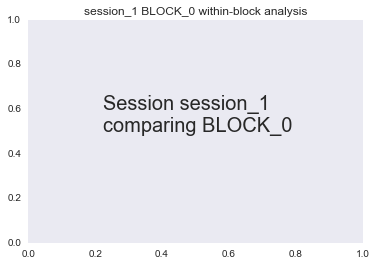

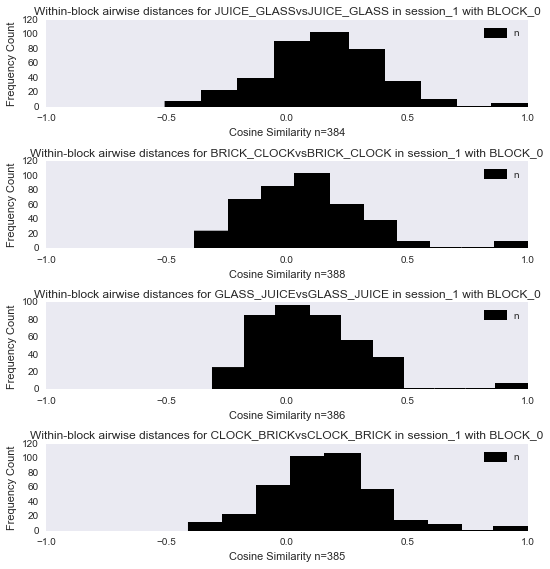

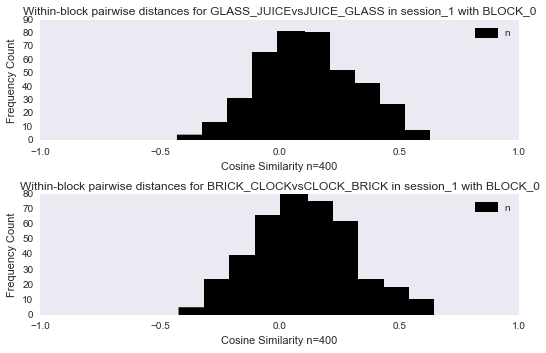

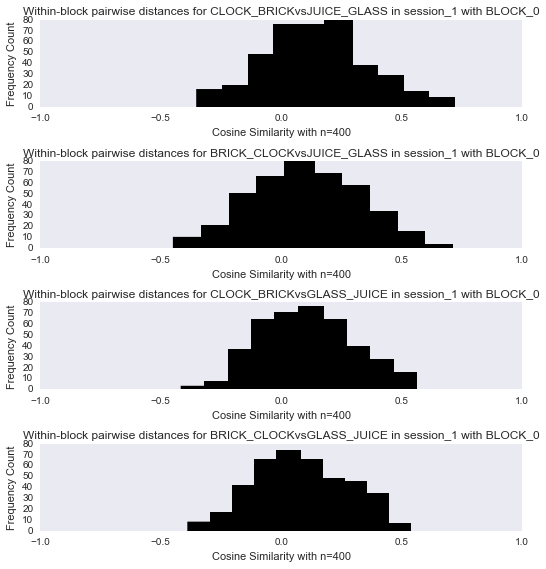

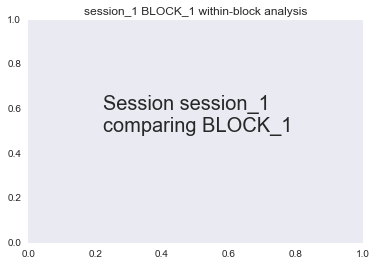

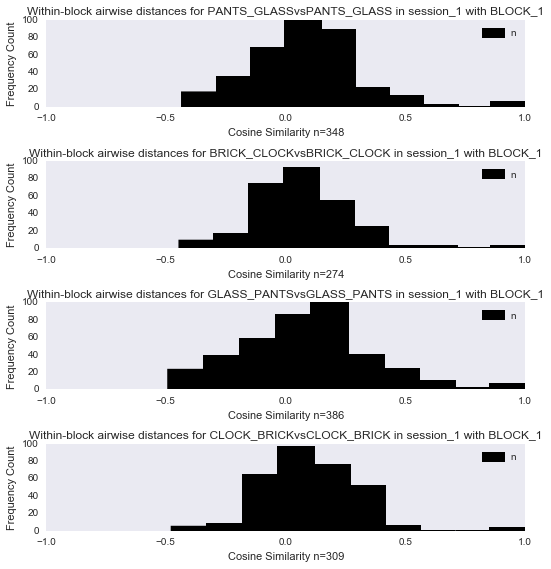

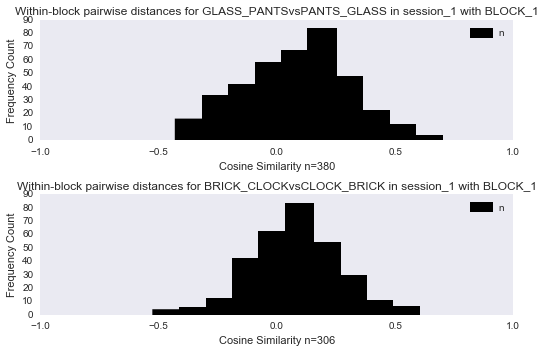

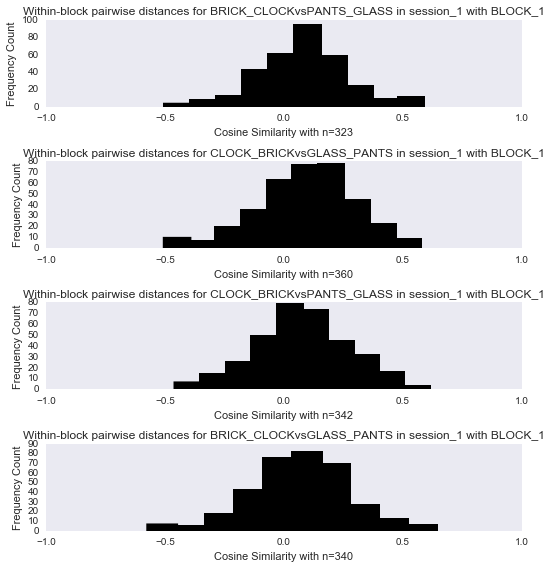

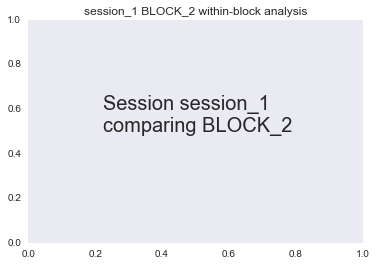

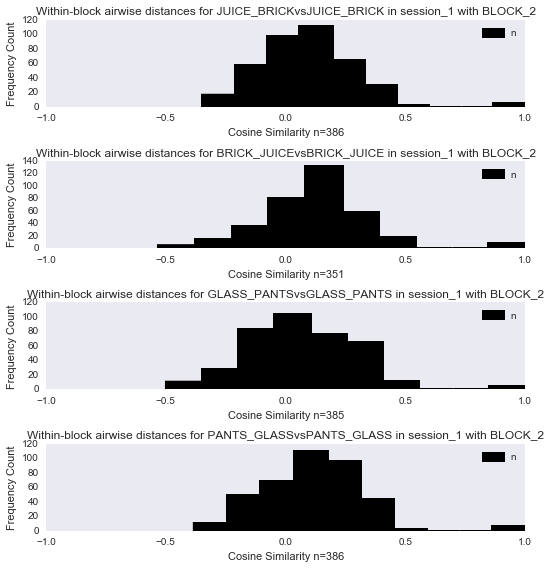

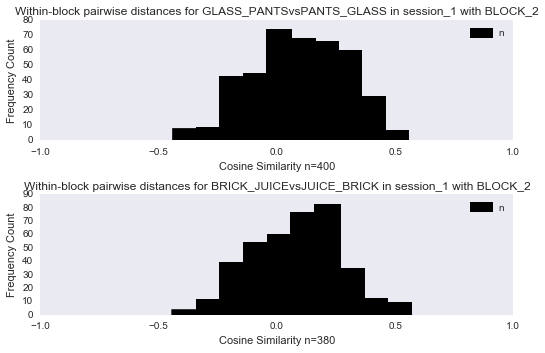

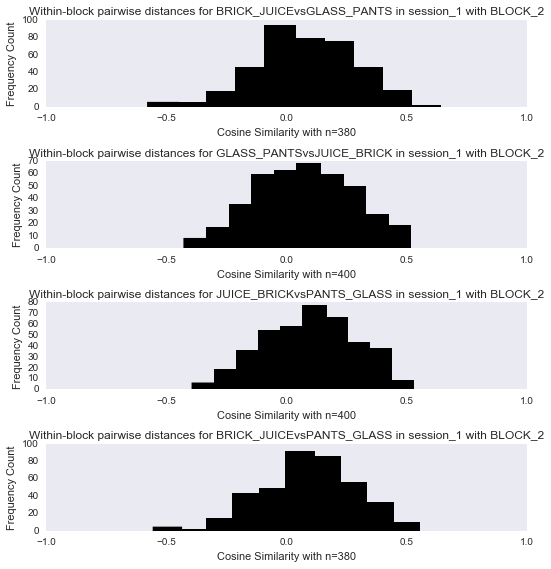

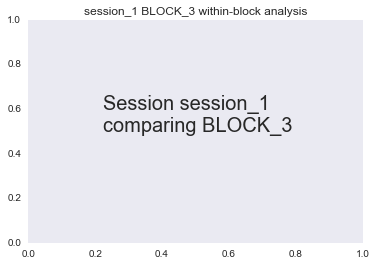

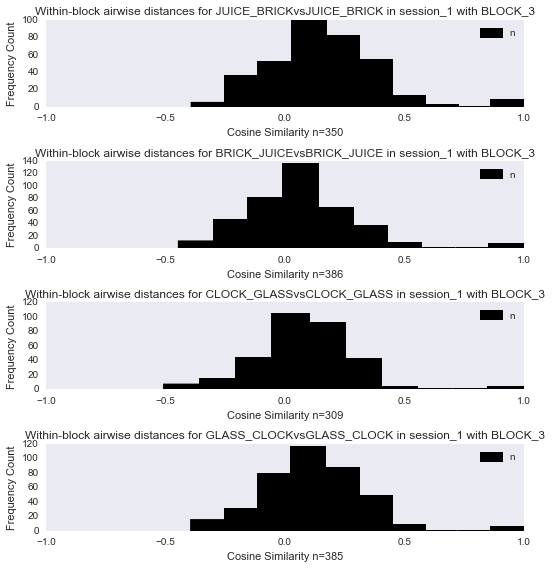

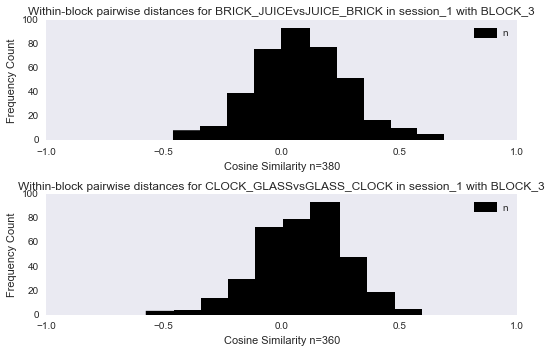

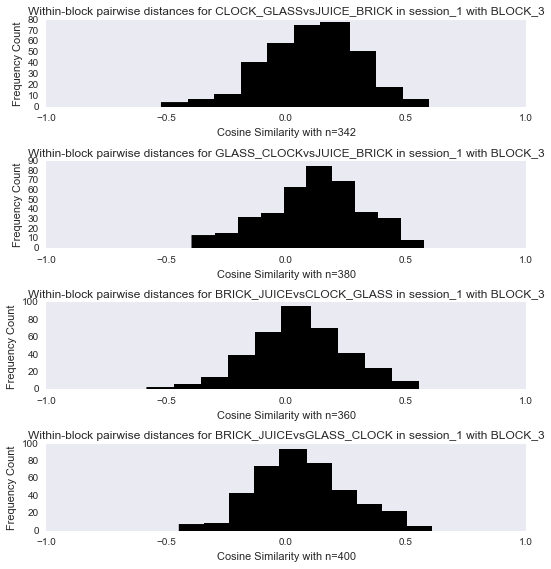

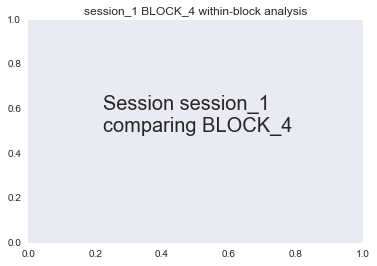

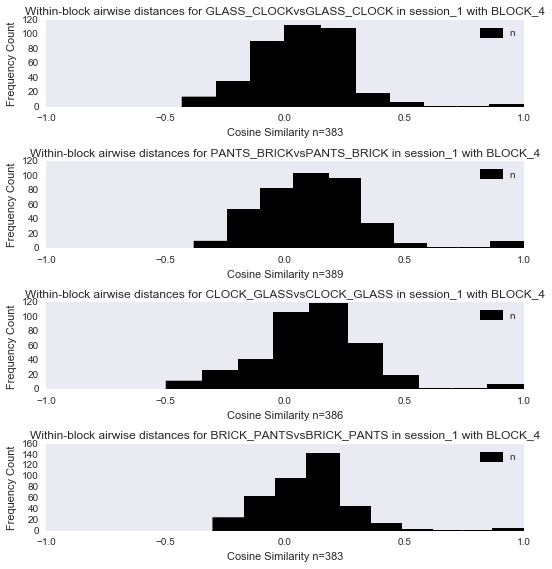

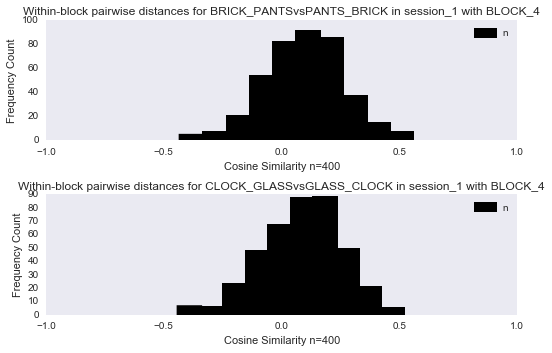

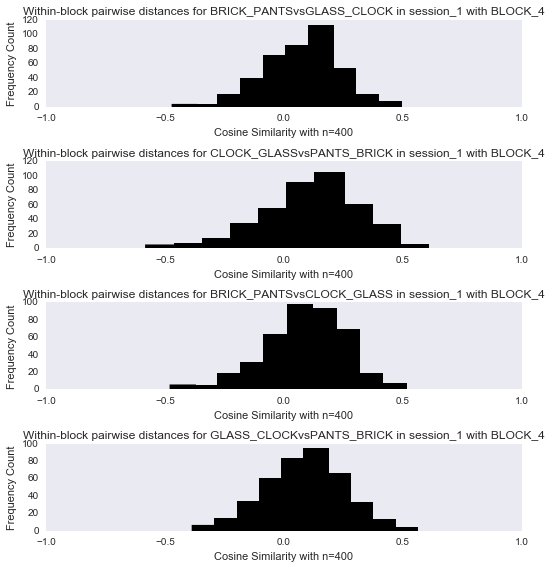

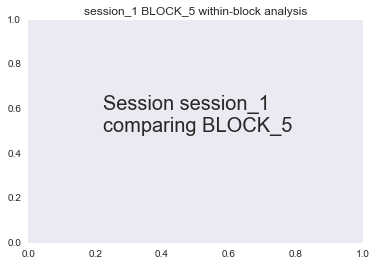

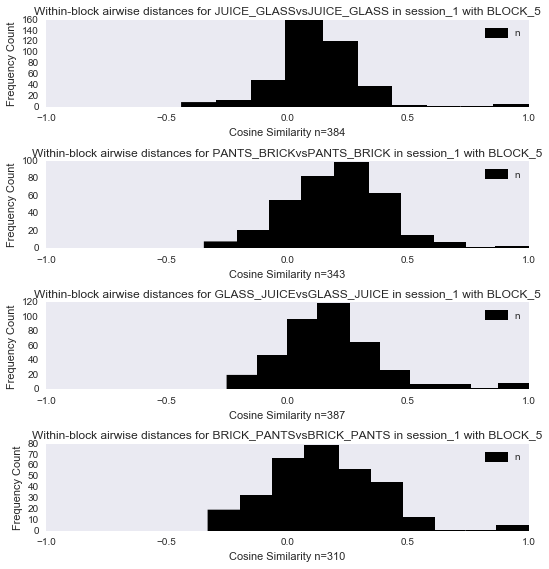

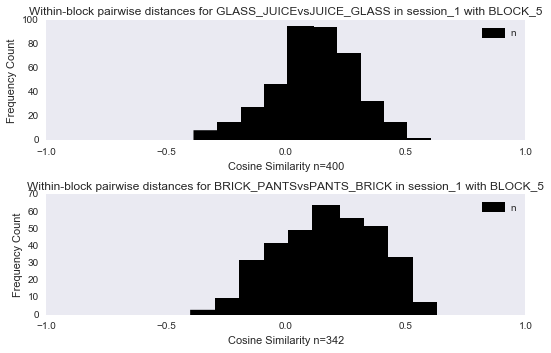

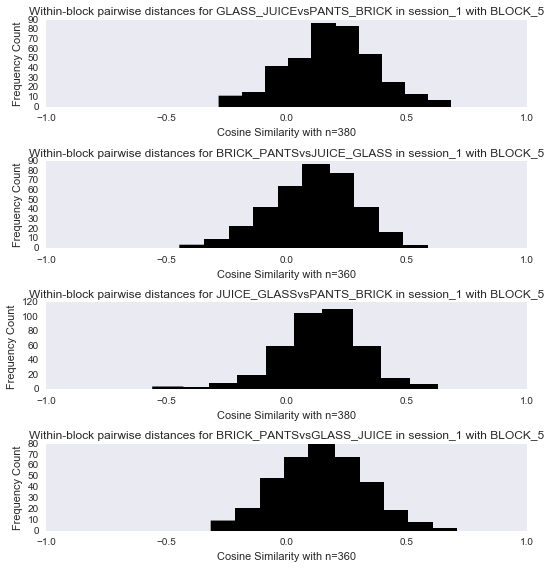

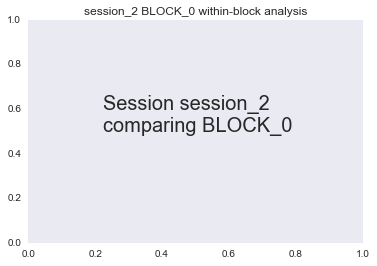

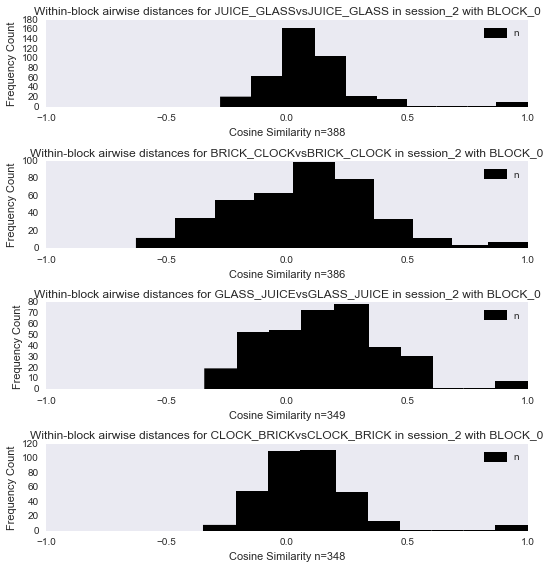

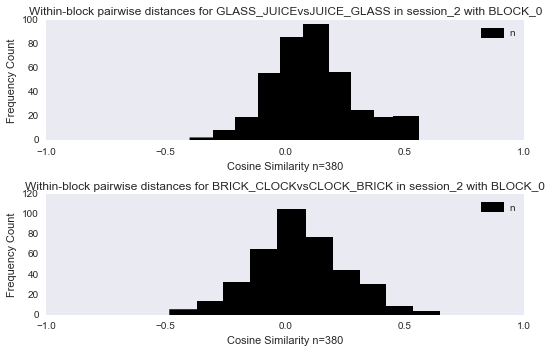

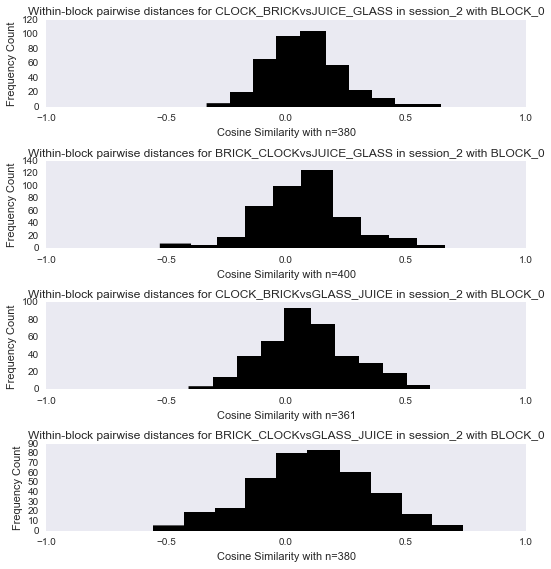

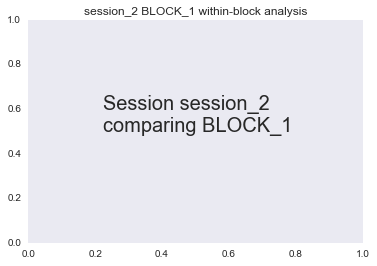

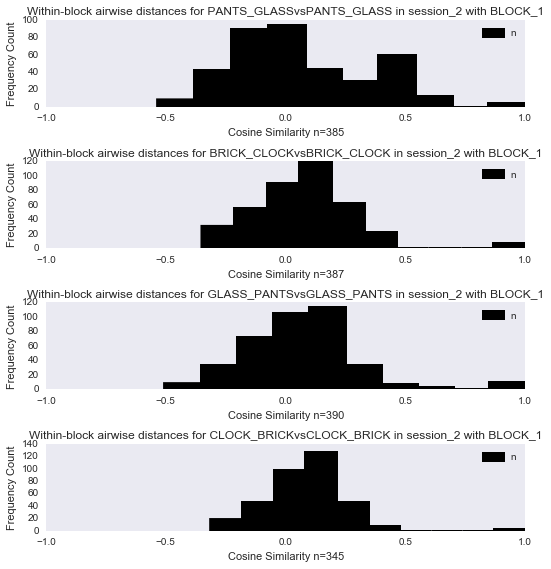

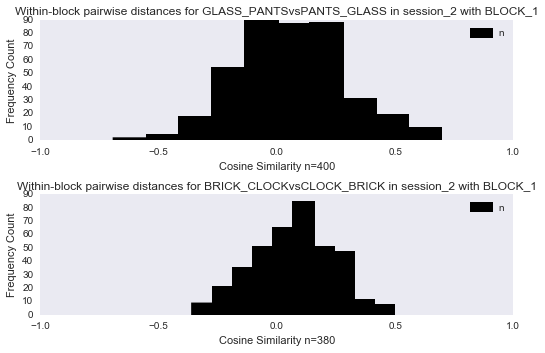

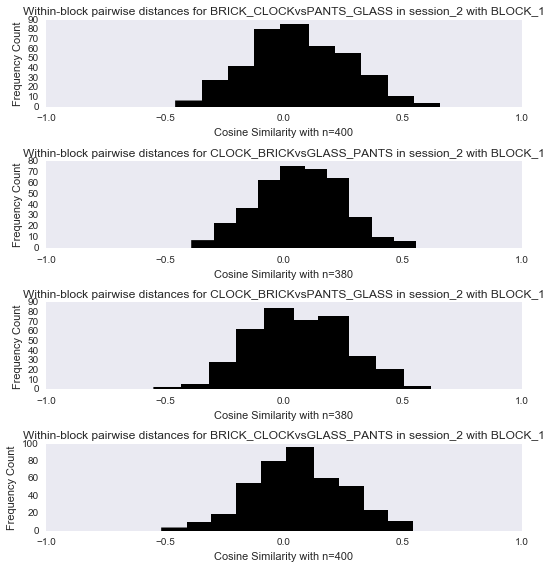

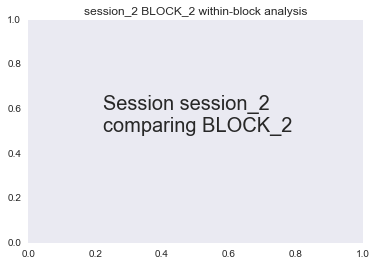

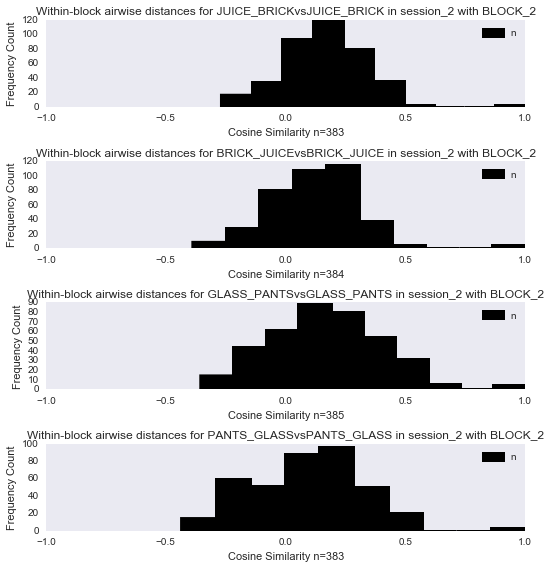

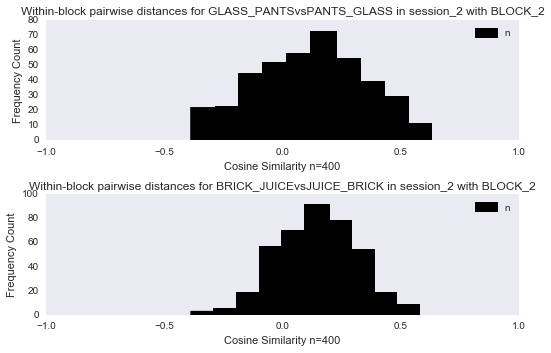

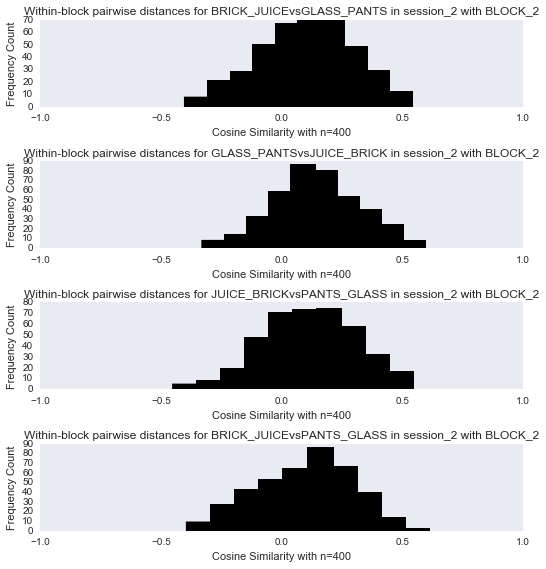

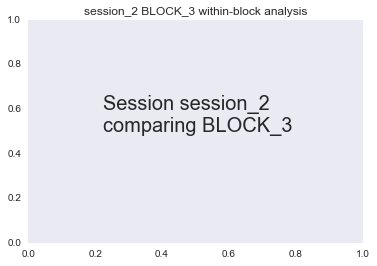

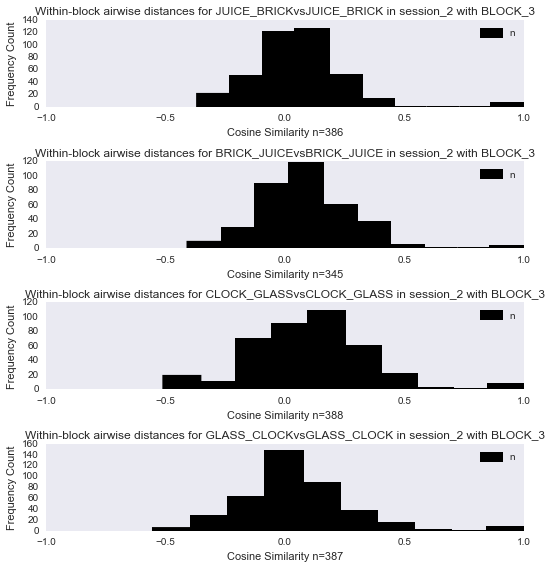

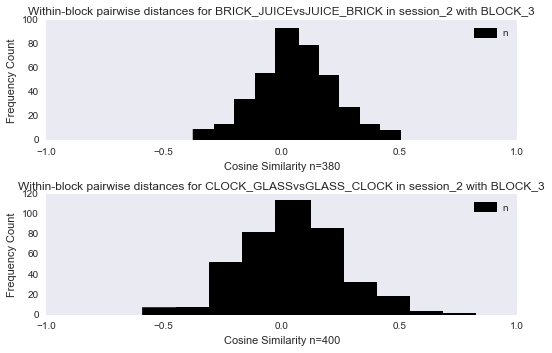

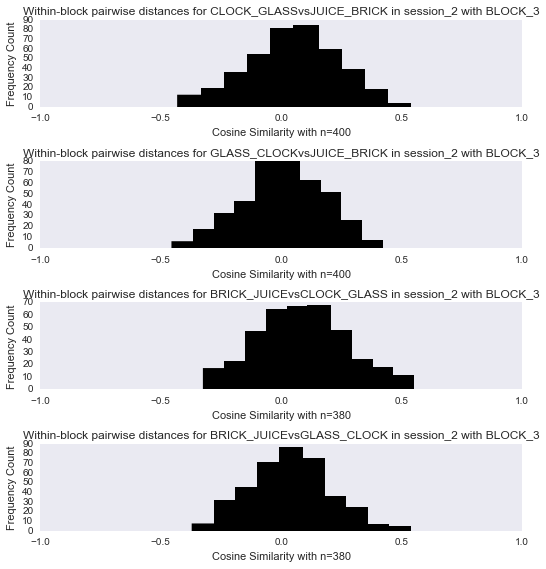

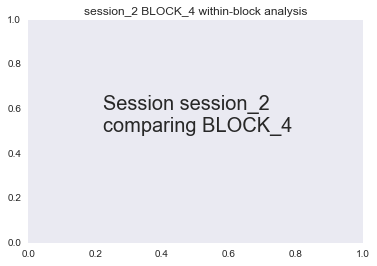

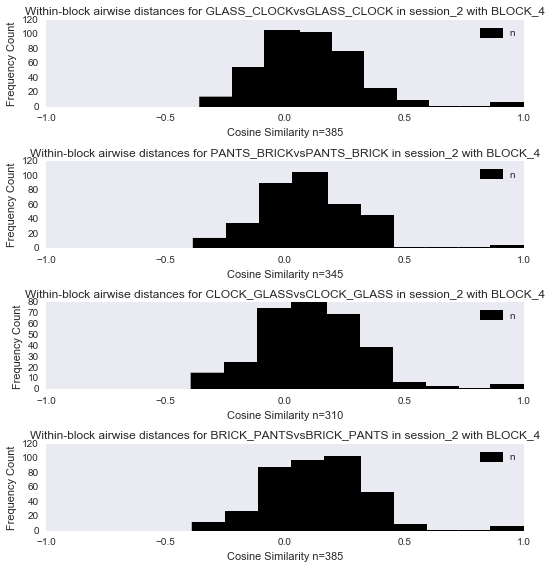

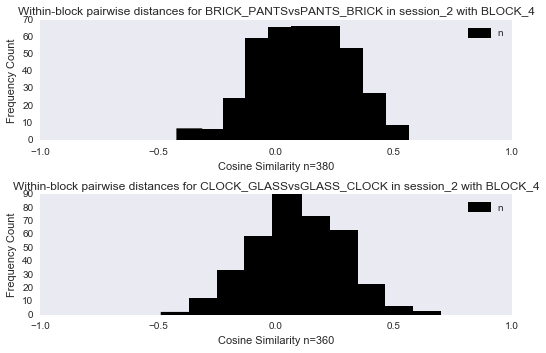

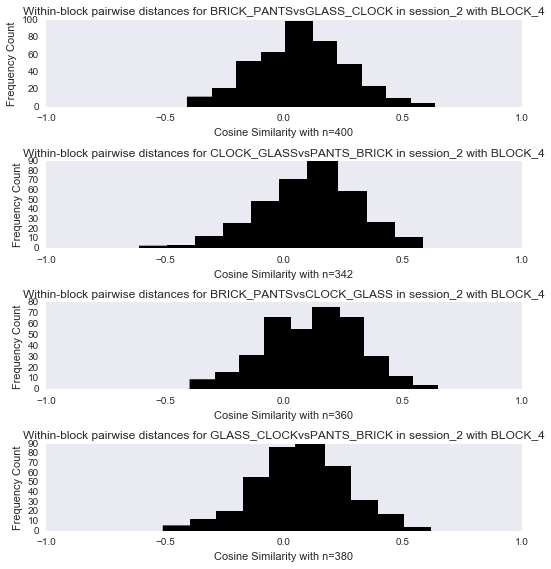

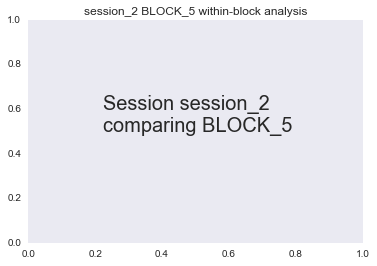

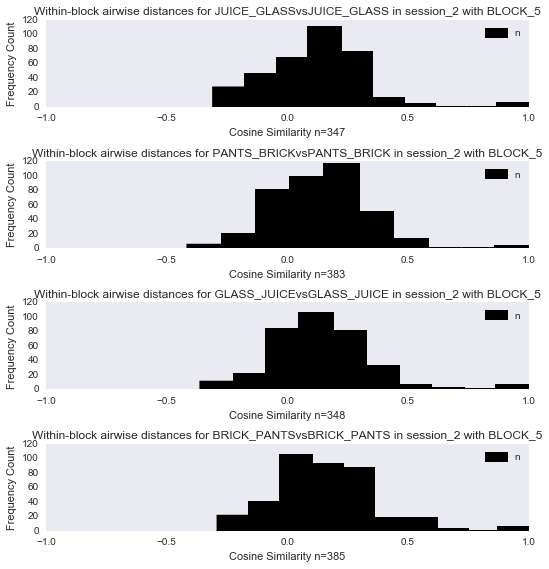

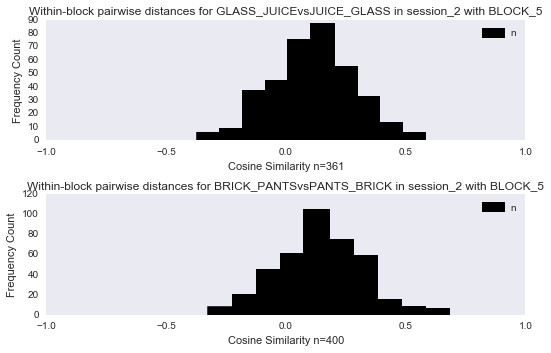

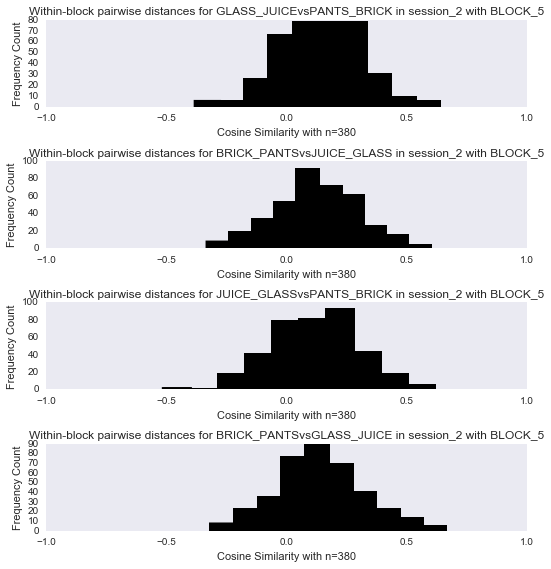

In [61]:
def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
         
   
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])

        # debugging check
#         print same_word_group
#         print reverse_word_group
#         print diff_word_group[0:2]
        
        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeatures(same_word_group,session,block,block_dir)
        reverse_feature_dict = extractFeatures(reverse_word_group,session,block,block_dir)
        diff_feature_dict = extractFeatures(diff_word_group,session,block,block_dir)
        
        print 'Done'
           
        same_distances = np.array(())
        reverse_distances = np.array(())
        diff_distances = np.array(())
        ######################################## SAME WORD PAIRS ########################################
        fig = plt.figure(figsize=(8,8))
        p_val = 0
        anova_list = {}
        for idx, comp in enumerate(same_feature_dict.keys()):
            distance_hist = computePairDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
            distance_hist = 1-distance_hist[distance_hist > 0]
            
#             same_distances.append(distance_hist)
            same_distances = np.append(same_distances, distance_hist, axis=0)
    
            anova_list[str(idx)] = distance_hist
#             group_lens.append((idx+1)*len(distance_hist))
            print "Analyzing ", comp
            
            sub = plt.subplot(len(same_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
            plt.ylabel('Frequency Count')
            plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' with ' + block)
            plt.xlim([-1,1])
            plt.legend(r'n= %s'%(str(len(distance_hist))))
        plt.tight_layout()
        
        # perform ANOVA on same groups
        print anova_list.keys()
        stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'])
        print "Same groups ANOVA has p-val: ", p_val
        
        ######################################## REVERSED WORD PAIRS ########################################
        fig = plt.figure(figsize=(8,5))
        stat_pair_list = {}
        for idx, comp in enumerate(reverse_feature_dict.keys()):
            distance_hist = 1-computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
            print "Analyzing ", comp
            
            stat_pair_list[str(idx)] = distance_hist
#             reverse_distances.append(distance_hist.tolist())
            reverse_distances = np.append(reverse_distances, distance_hist)
    
            sub = plt.subplot(len(reverse_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
            plt.ylabel('Frequency Count')
            plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
            plt.xlim([-1,1])
            plt.legend(r'n= %s'%(str(len(distance_hist))))
        plt.tight_layout()
        
        # perform Wilcoxon
        stat, p_val = stats.ranksums(stat_pair_list['0'], stat_pair_list['1'])
        print stat_pair_list.keys()
        print "Reverse groups Wilcoxon Signed Rank Test has p-val: ", p_val
            
        ####################################### DIFFERENT WORD PAIRS ########################################
        fig = plt.figure(figsize=(8,8))
        anova_list = {}
        for idx, comp in enumerate(diff_feature_dict.keys()):
            distance_hist = 1-computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
            print "Analyzing ", comp
            
            anova_list[str(idx)] = distance_hist
#             diff_distances.append(distance_hist.tolist())
            diff_distances = np.append(diff_distances, distance_hist)
    
            sub = plt.subplot(len(diff_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Similarity with n='+str(len(distance_hist)))
            plt.ylabel('Frequency Count')
            plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
            plt.xlim([-1,1])
            
        plt.tight_layout()
        
        # perform ANOVA on same groups
        print anova_list.keys()
        stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'])
        print "Different groups ANOVA has p-val: ", p_val
        
        # convert group distances to np array
#         same_distances = np.array(same_distances)
#         reverse_distances = np.ndarray.flatten(np.array(reverse_distances))
#         diff_distances = np.ndarray.flatten(np.array(diff_distances))
        
        stat, p_val = stats.f_oneway(same_distances[:], reverse_distances[:], diff_distances[:])
        print stat, ' and pval: ', p_val, ' for ANOVA'
        stat, p_val = stats.ranksums(same_distances, diff_distances)
        print stat, ' and pval: ', p_val, ' for Rank Sum Test of same vs. diff'
        
#         break # look at 1 block
#     break # look at 1 session

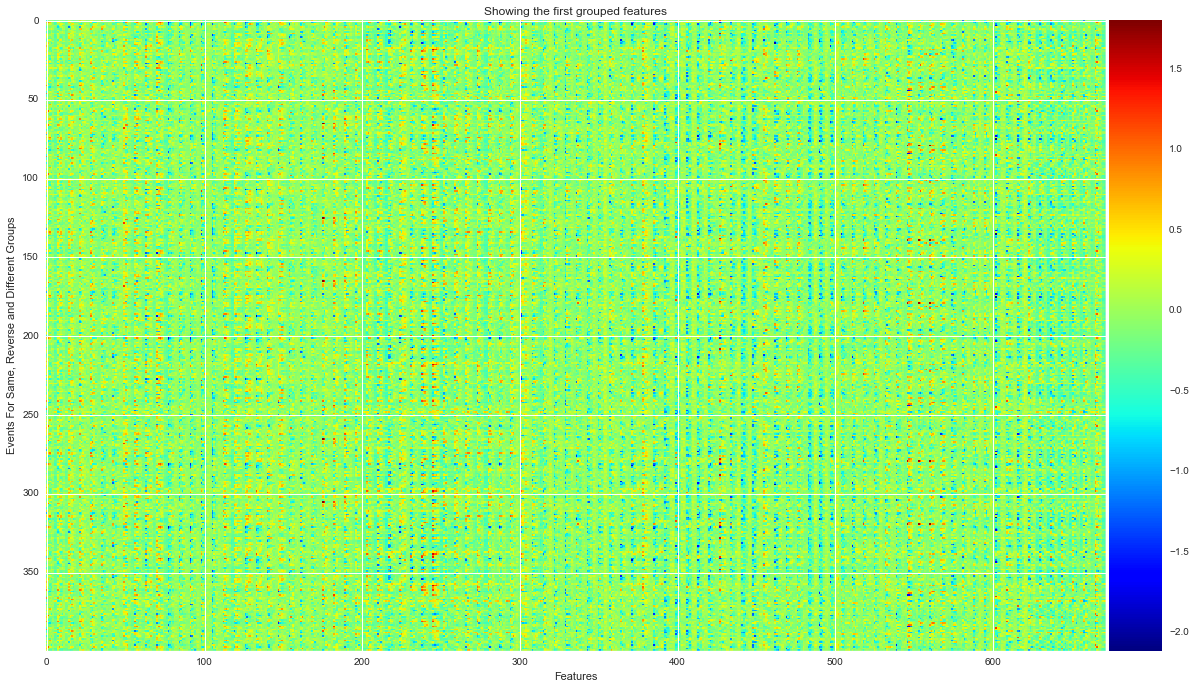

In [35]:
# same_feature_dict = extractFeatures(same_word_group,session,block,block_dir)
# reverse_feature_dict = extractFeatures(reverse_word_group,session,block,block_dir)
# diff_feature_dict = extractFeatures(diff_word_group,session,block,block_dir)

first_grouped_feature_mat = []
second_grouped_feature_mat = []
first_grouped_len = []
second_grouped_len = []
for key in same_feature_dict.keys():
    first_grouped_feature_mat.append(same_feature_dict[key][0])
    first_grouped_len.append(len(same_feature_dict[key][0]))
    second_grouped_feature_mat.append(same_feature_dict[key][1])
    second_grouped_len.append(len(same_feature_dict[key][1]))
for key in reverse_feature_dict.keys():
    first_grouped_feature_mat.append(reverse_feature_dict[key][0])
    first_grouped_len.append(len(reverse_feature_dict[key][0]))
    second_grouped_feature_mat.append(reverse_feature_dict[key][1])
    second_grouped_len.append(len(reverse_feature_dict[key][1]))
for key in diff_feature_dict.keys():
    first_grouped_feature_mat.append(diff_feature_dict[key][0])
    first_grouped_len.append(len(diff_feature_dict[key][0]))
    second_grouped_feature_mat.append(diff_feature_dict[key][1])
    second_grouped_len.append(len(diff_feature_dict[key][1]))

    
first_grouped_feature_mat = np.array(first_grouped_feature_mat).reshape(200, 672)
second_grouped_feature_mat = np.array(second_grouped_feature_mat).reshape(200,672)


fig = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(np.append(first_grouped_feature_mat,second_grouped_feature_mat, axis=0), interpolation='none', cmap='jet')
plt.xlabel('Features')
plt.ylabel('Events For Same, Reverse and Different Groups')
plt.title('Showing the first grouped features')
vmin, vmax = plt.gci().get_clim()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
# im.set_clim([-0.2, 0.2])


## Looking at Each Session Across Block Analysis Within a Session

1. Get data structure of same groups, reverse groups, and different groups
2. For each block concatenate these groups, and compare with the block above it (block(i) vs. block(i+1))


        r=[
    1,32;		% G		(left temporal grid)
    33,38;		% TT		(left temporal tip)
    39,42;		% OF		(left orbitofrontal)
    43,46;		% AST		(left anterior subtemporal)
    47,50;		% MST		(left middle subtemporal)
    51,54;		% PST		(left posterior subtemporal)
    55,60;		% IO		(left inferior occipital)
    61,66;		% MO		(left left middle occipital)
    67,72;		% SO		(left superior occipital)
    73,80;		% PP		(left posterior parietal)
    81,86;		% LP		(left lateral parietal)
    87,90;		% PPST		(left posterior posterior subtemporal)
    91,96;		% LF		(left lateral frontal)
    ];
    

In [96]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1]
# freq_bands = np.arange(0,7,1)

channels_we_want = np.arange(54,60,1)
# channels_we_want = np.arange(0,96,1)

np.random.seed(123456789)  # for reproducibility, set random seed

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0, 1]
['delta', 'theta']
The length of the feature vector for each channel will be:  10


In [97]:
def find_same(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    sameword_index = []
    try:
        sameword_index.append(groups.index(wordpair))
    except:
        sameword_index.append(-1)
    return sameword_index
def find_reverse(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')
    wordsplit.reverse()
    reverseword = '_'.join(wordsplit)
    
    reverseword_index = []
    # find index of reversed word index
    try:
        reverseword_index.append(groups.index(reverseword))
    except:
        reverseword_index.append(-1)
    
    return reverseword_index
def find_different(wordpair, groups):
    # split wordpair and reverse
    wordsplit = wordpair.split('_')    
    differentword_index = []
    
    for idx, group in enumerate(groups):
        groupsplit = group.split('_')
        if not any(x in groupsplit for x in wordsplit):
            differentword_index.append(idx)
    
    return differentword_index

def inGroup(group, names):
    for i in range(0, len(group)):
        if cmpT(group[i],names):
            return True
    return False

def cmpT(t1, t2): 
    return sorted(t1) == sorted(t2)

In [98]:
### Functions to help extract features and plot histogram of distances
# loops through each wordpairing group and extract features
def extractFeatures(wordgroup, firstblock_dir, secondblock_dir):
    PairFeatureDict = {}
    ## loop through pairs in this word group
    for idx, pair in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = firstblock_dir + '/' + pair[0]
        second_wordpair_dir = secondblock_dir + '/' + pair[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels
        channels = os.listdir(first_wordpair_dir)
        # loop through channels
        for jdx, chans in enumerate(channels):
            if jdx in channels_we_want:
                first_chan_file = first_wordpair_dir + '/' + chans
                second_chan_file = second_wordpair_dir + '/' + chans

                ## 00: load in data
                data_first = scipy.io.loadmat(first_chan_file)
                data_first = data_first['data']
                data_second = scipy.io.loadmat(second_chan_file)
                data_second = data_second['data']

                ## 01: get the time point for probeword on
                first_timeZero = data_first['timeZero'][0][0][0]
                second_timeZero = data_second['timeZero'][0][0][0]

                ## 02: get the time point of vocalization
                first_vocalization = data_first['vocalization'][0][0][0]
                second_vocalization = data_second['vocalization'][0][0][0]

                ## 03: Get Power Matrix
                first_matrix = data_first['powerMatZ'][0][0]
                second_matrix = data_second['powerMatZ'][0][0]
                first_matrix = first_matrix[:, freq_bands,:]
                second_matrix = second_matrix[:, freq_bands,:]

                ### 02: get only the time point before vocalization
                first_mean = []
                second_mean = []
                for i in range(0, len(first_vocalization)):
                    # either go from timezero -> vocalization, or some other timewindow
                    first_mean.append(np.mean(first_matrix[i,:,first_timeZero:first_vocalization[i]-2], axis=1))
    #                     first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
                for i in range(0, len(second_vocalization)):
                    second_mean.append(np.mean(second_matrix[i,:,second_timeZero:second_vocalization[i]-2], axis=1))
    #                     second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))

                # create feature vector for each event
                if len(first_pair_features)==0:
                    first_pair_features.append(first_mean)
                    second_pair_features.append(second_mean)
                    first_pair_features = np.squeeze(np.array(first_pair_features))
                    second_pair_features = np.squeeze(np.array(second_pair_features))
                else:
                    first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                    second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels
        
        # should be #events X #features (channels x freq. bands x time points)
#         if idx==0:
#             print first_pair_features.shape
#             print second_pair_features.shape
        # add to overall dictionary for each comparison word for return statement at end
        pairName = pair[0] + 'vs' + pair[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict

Analyzing session  session_1
Analyzing block  BLOCK_0  and  BLOCK_1
-------------------------------------------------
Finished processing into wordpair_group dictionaries for  A feature matrix has shape:  (20, 12)
['BRICK_CLOCKvsBRICK_CLOCK', 'CLOCK_BRICKvsCLOCK_BRICK']
['BRICK_CLOCKvsCLOCK_BRICK']
['CLOCK_BRICKvsGLASS_PANTS', 'JUICE_GLASSvsBRICK_CLOCK', 'BRICK_CLOCKvsPANTS_GLASS', 'JUICE_GLASSvsCLOCK_BRICK', 'BRICK_CLOCKvsGLASS_PANTS', 'GLASS_JUICEvsCLOCK_BRICK', 'GLASS_JUICEvsBRICK_CLOCK', 'CLOCK_BRICKvsPANTS_GLASS']
Analyzing  BRICK_CLOCKvsBRICK_CLOCK
Analyzing  CLOCK_BRICKvsCLOCK_BRICK
['1', '0']
Same groups ANOVA has p-val:  0.321820601272
Analyzing  BRICK_CLOCKvsCLOCK_BRICK
Analyzing  CLOCK_BRICKvsGLASS_PANTS
Analyzing  JUICE_GLASSvsBRICK_CLOCK
Analyzing  BRICK_CLOCKvsPANTS_GLASS
Analyzing  JUICE_GLASSvsCLOCK_BRICK
Analyzing  BRICK_CLOCKvsGLASS_PANTS
Analyzing  GLASS_JUICEvsCLOCK_BRICK
Analyzing  GLASS_JUICEvsBRICK_CLOCK
Analyzing  CLOCK_BRICKvsPANTS_GLASS
['1', '0', '3', '2', '5

/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


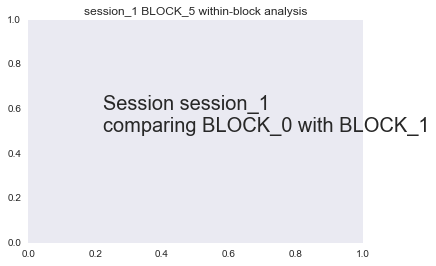

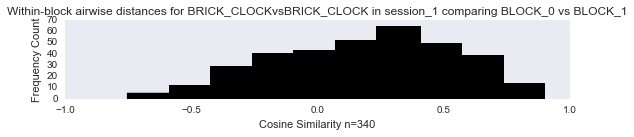

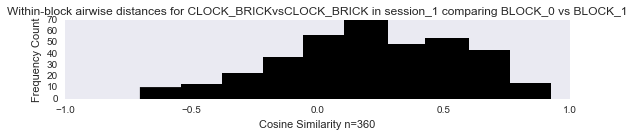

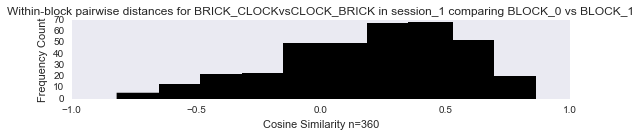

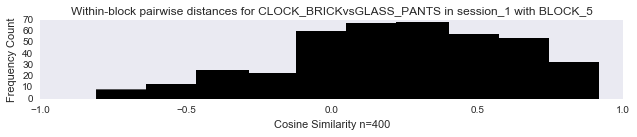

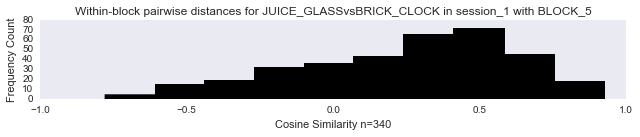

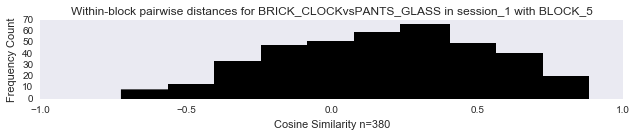

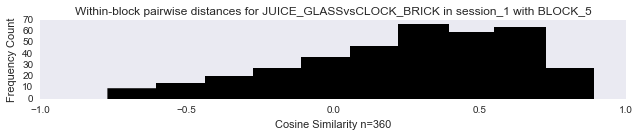

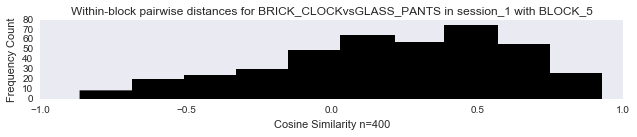

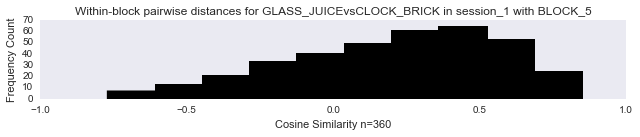

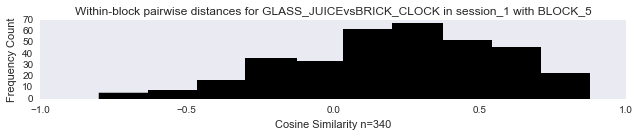

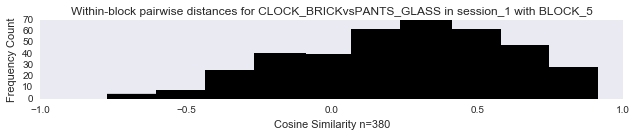

In [99]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for sdx, session in enumerate(sessions):
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break

    # loop through each block one at a time, analyzing block(i) vs. block(i+1)
    for i in range(0, 5):
        print "Analyzing block ", blocks[i], ' and ', blocks[i+1]
        print "-------------------------------------------------"
        firstblock = blocks[i]
        secondblock = blocks[i+1]
        
        # in each block, get list of word pairs from first and second block
        firstblock_dir = sessiondir+'/'+firstblock
        secondblock_dir = sessiondir+'/'+secondblock
        firstblock_wordpairs = os.listdir(firstblock_dir)
        secondblock_wordpairs = os.listdir(secondblock_dir)
    
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s with %s'%(session, '\n',firstblock, secondblock), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        # across-blocks analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        # go through first block and assign pairs to different groups
        for idx, first_pair in enumerate(firstblock_wordpairs):            
            # obtain indices of: sameword, reverseword, differentwords, probeoverlap, targetoverlap
            same_word_index = find_same(first_pair, secondblock_wordpairs)
            reverse_word_index = find_reverse(first_pair, secondblock_wordpairs)
            diff_word_index = find_different(first_pair, secondblock_wordpairs)
            
            # append to list groupings holding pairs of these word groupings
            if -1 not in same_word_index:
                for sameI in same_word_index:
                    if not inGroup(same_word_group, [first_pair, secondblock_wordpairs[sameI]]):
                        same_word_group.append([first_pair, secondblock_wordpairs[sameI]])
            if -1 not in reverse_word_index: 
                for reverseI in reverse_word_index:     # loop through each different word index
                    if not inGroup(reverse_word_group, [first_pair, secondblock_wordpairs[reverseI]]):
                        reverse_word_group.append([first_pair, secondblock_wordpairs[reverseI]])
            if -1 not in diff_word_index:
                for diffI in diff_word_index:     # loop through each different word index
                    if not inGroup(diff_word_group, [first_pair, secondblock_wordpairs[diffI]]):
                        diff_word_group.append([first_pair, secondblock_wordpairs[diffI]])
    
        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeatures(same_word_group, firstblock_dir, secondblock_dir)
        reverse_feature_dict = extractFeatures(reverse_word_group, firstblock_dir, secondblock_dir)
        diff_feature_dict = extractFeatures(diff_word_group, firstblock_dir, secondblock_dir)

        print 'Finished processing into wordpair_group dictionaries for ', 
        print 'A feature matrix has shape: ', same_feature_dict[same_feature_dict.keys()[0]][0].shape
            
        # end of loop through word pairs
    # end of loop through blocks
    
        # debugging check
#         print same_word_group
#         print reverse_word_group
#         print diff_word_group
    
        print same_feature_dict.keys()
        print reverse_feature_dict.keys()
        print diff_feature_dict.keys()
    
        ######################################## SAME WORD PAIRS ########################################
#         fig = plt.figure(figsize=(9,6))
        p_val = 0
        anova_list = {}
        for idx, comp in enumerate(same_feature_dict.keys()):
            distance_hist = computePairDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
            distance_hist = 1-distance_hist[distance_hist > 0]
            
            anova_list[str(idx)] = distance_hist
#             group_lens.append((idx+1)*len(distance_hist))
            print "Analyzing ", comp
            
            fig = plt.figure(figsize=(9,2))
#             sub = plt.subplot(len(same_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
            plt.ylabel('Frequency Count')
            plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' comparing ' + firstblock + ' vs ' + secondblock)
            plt.xlim([-1,1])
            plt.tight_layout()
        
        # perform ANOVA on same groups
        print anova_list.keys()
        stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'])
        print "Same groups ANOVA has p-val: ", p_val
        
        ######################################## REVERSED WORD PAIRS ########################################
#         fig = plt.figure(figsize=(7,3))
        for idx, comp in enumerate(reverse_feature_dict.keys()):
            distance_hist = 1-computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
            print "Analyzing ", comp
            
            fig = plt.figure(figsize=(9,2))
            sub = plt.subplot(len(reverse_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
            plt.ylabel('Frequency Count')
            plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' comparing ' + firstblock + ' vs ' + secondblock)
            plt.xlim([-1,1])
            plt.tight_layout()
        
        ####################################### DIFFERENT WORD PAIRS ########################################
#         fig = plt.figure(figsize=(9,24))
        anova_list = {}
        for idx, comp in enumerate(diff_feature_dict.keys()):
            distance_hist = 1-computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
            print "Analyzing ", comp
            
            anova_list[str(idx)] = distance_hist
            
            fig = plt.figure(figsize=(9,2))
#             sub = plt.subplot(len(diff_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Similarity n='+str(len(distance_hist)))
            plt.ylabel('Frequency Count')
            plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
            plt.xlim([-1,1])
            plt.tight_layout()
        
        # perform ANOVA on same groups
        print anova_list.keys()
        stat, p_val = stats.f_oneway(anova_list['0'], anova_list['1'], anova_list['2'], anova_list['3'], anova_list['4'], anova_list['5'], anova_list['6'], anova_list['7'])
        print "Different groups ANOVA has p-val: ", p_val
        
#         break
        break # look at 1 block
    break # look at 1 session

# Discussion:
